In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ease

In [2]:
def rf(prec, ts, tw, ws):
    """
    This function is RandomForest classifier to intake user input temperature,
    precipitation, and windespeed to classify the possible states the user
    will be in, and returns a dictionary with states as the keys and
    the frequency or count as the values of each key.
       input = user input values, integer or float based.
       vote  = dictionary based output that contains the RF classified states,
               and each states frequency.
    """
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    import itertools as it
    import warnings

    train = pd.read_csv('../Arranged_Data/final_weater.csv')[[
            'State', 'TotalMonthlyPrecip', 'TempSummer',
            'TempWinter', 'Avgwindspeed']]
    train = train[train.State != 'DC']

    warnings.filterwarnings('ignore')

    input_ = [prec, ts, tw, ws]
    tree_num = 100
    pred_list = []
    vote = {}
    rf = RandomForestClassifier(n_estimators = tree_num)
    rf.fit(train.iloc[:,1:5], train.State)

    for i in range(tree_num):
        dt = rf.estimators_[i]
        dt.fit(train.iloc[:,1:5], train.State)
        pred = dt.predict(input_)
        pred_list.append(pred[0])

    pred_key = []
    pred_key_count = []
    for key, group in it.groupby(sorted(pred_list)):
        pred_key.append(key)
        pred_key_count.append(len(list(group)))

    for i in range(len(pred_key)):
        vote[pred_key[i]] = pred_key_count[i]/tree_num
    return vote

In [3]:
def avg_capacity(vote):
    import pandas as pd
    average_plant_capacity = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    avg_cap_list = []
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(average_plant_capacity.Coal[average_plant_capacity.State == i]) * vote[i]
        ng_sum += int(average_plant_capacity.NG[average_plant_capacity.State == i]) * vote[i]
        petro_sum += int(average_plant_capacity.Petro[average_plant_capacity.State == i]) * vote[i]
        hydro_sum += int(average_plant_capacity.Hydro[average_plant_capacity.State == i]) * vote[i]
        solar_sum += int(average_plant_capacity.Solar[average_plant_capacity.State == i]) * vote[i]
        wind_sum += int(average_plant_capacity.Wind[average_plant_capacity.State == i]) * vote[i]
    return([coal_sum, ng_sum, petro_sum, hydro_sum, solar_sum, wind_sum])

In [4]:
cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
cap_pop[cap_pop.Coal != 0].Coal.mean()

2878153.5744680851

In [5]:
def possible_type(avg_cap_list):
    import pandas as pd
    from scipy import stats
    cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    e_type = ['Coal', 'NG', 'Petro', 'Hydro', 'Solar', 'Wind']
    possible_type_list = []
    for i in range(len(e_type)):
        p_value = stats.ttest_1samp(cap_pop[cap_pop[e_type[i]] != 0][e_type[i]], avg_cap_list[i])[1]
        alpha = 0.05  #confidence
        if avg_cap_list[i] < cap_pop[cap_pop[e_type[i]] !=0][e_type[i]].mean():
            if p_value < alpha:
                pass
            else:
                p_value = -(1 - p_value)
                possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
        else:
            p_value = (1 - p_value)
            possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
    return possible_type_list

In [6]:
possible_type([3427272.05, 601160.0700000001, 132529.37000000002, 159063.21, 2253.23, 149414.79999999996])

[[0.95810457341493549, 3427272.05, 'Coal'],
 [-0.8923811497455455, 601160.0700000001, 'NG'],
 [0.99926594657247059, 132529.37000000002, 'Petro'],
 [-0.90421357886564524, 159063.21, 'Hydro'],
 [-0.83811357367028649, 149414.79999999996, 'Wind']]

In [7]:
ease.rf(2, 75, 30, 1.5)

{'CT': 0.01,
 'GA': 0.03,
 'IL': 0.02,
 'IN': 0.01,
 'KY': 0.11,
 'MD': 0.02,
 'MO': 0.01,
 'NJ': 0.16,
 'OR': 0.03,
 'SC': 0.01,
 'TN': 0.01,
 'VA': 0.02,
 'VT': 0.01,
 'WA': 0.02,
 'WV': 0.53}

In [8]:
a = ease.avg_capacity(ease.rf(2, 75, 30, 1.5))
a

[3665239.2100000004,
 639412.19,
 107674.43,
 128850.12000000001,
 2499.8999999999996,
 168917.0]

In [9]:
b = ease.possible_type(a)

In [20]:
def rev_plot(avg_cost, capacity, e_type, label):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    esales = pd.read_csv('../Arranged_Data/Cost/Sale_CO2_tax.csv', skiprows= 1, names = ['Year', 'Sale', 'CO2_tax'])
    if e_type == 'conventional':
        revenue = (esales.Sale - esales.CO2_tax - avg_cost) * capacity * 365 * 24 / 1e6
    elif e_type == 'clean':
        revenue = (esales.Sale - avg_cost) * capacity * 365 * 24 / 1e6
    plt.plot(np.arange(2018, 2051), revenue[3:], label=label)
    plt.xlabel('Year')
    plt.ylabel('Money Save (million dollars / year)')
    plt.legend()
    plt.grid()
    return plt

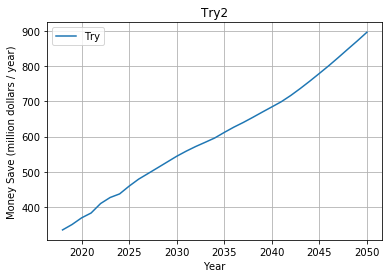

In [21]:
a = rev_plot(30, 500, 'clean', 'Try')
a.title('Try2')

In [12]:
np.array(b)[:, 2]

array(['Coal', 'NG', 'Petro', 'Wind'], 
      dtype='<U32')

In [13]:
def avg_cost(vote):
    import pandas as pd
    cost = pd.read_csv('../Arranged_Data/Cost/df_cost.csv')
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(cost.Coal[cost.State == i]) * vote[i]
        ng_sum += int(cost.NG[cost.State == i]) * vote[i]
        petro_sum += int(cost.Petro[cost.State == i]) * vote[i]
        hydro_sum += int(cost.Hydro[cost.State == i]) * vote[i]
        solar_sum += int(cost.solar[cost.State == i]) * vote[i]
        wind_sum += int(cost.WindCost[cost.State == i]) * vote[i]
    avg_cost_dict = {'Coal':coal_sum, 'NG':ng_sum, 'Petro':petro_sum, 'Hydro':hydro_sum, 'Solar':solar_sum, 'Wind':wind_sum}
    return avg_cost_dict

In [14]:
avg_cost(ease.rf(2, 75, 30, 1.5))

{'Coal': 24.720000000000002,
 'Hydro': 85.0,
 'NG': 52.75,
 'Petro': 165.7,
 'Solar': 126.82999999999998,
 'Wind': 37.04}

In [15]:
def clean_or_conv(possible_type_list):
    clean_list = []
    conventional_list = []
    for i in possible_type_list:
        if i[2] == 'Coal' or i[2] == 'NG' or i[2] == 'Petro':
            conventional_list.append(i)
        elif i[2] == 'Hydro' or i[2] == 'Solar' or i[2] == 'Wind':
            clean_list.append(i)
    return conventional_list, clean_list

In [16]:
conv, clean = clean_or_conv([[0.95810457341493549, 3427272.05, 'Coal'],
 [-0.8923811497455455, 601160.0700000001, 'NG'],
 [0.99926594657247059, 132529.37000000002, 'Petro'],
 [-0.90421357886564524, 159063.21, 'Hydro'],
 [-0.83811357367028649, 149414.79999999996, 'Wind']])
clean

[[-0.9042135788656452, 159063.21, 'Hydro'],
 [-0.8381135736702865, 149414.79999999996, 'Wind']]

In [17]:
def suggest(prec, ts, tw, ws, capacity):
    state_vote = rf(prec, ts, tw, ws)
    cap = avg_capacity(state_vote)
    cost = avg_cost(state_vote)
    source_list = possible_type(cap)
    conventional, clean = clean_or_conv(source_list)
    conventional.sort()
    clean.sort()
    if len(clean) == 0:
        capacity = min([conventional[-1][1], capacity])
        revenue_clean = None
        revenue_conv = rev_plot(cost[conventional[-1][2]], capacity, 'conventional')
        revenue_conv.title('Money Save using ' + conventional[-1][2] + ' (capacity = ' + str(capacity) + ' Mwh)')
    else:
        if clean[-1][1] >= capacity:
            revenue_clean = rev_plot(cost[clean[-1][2]], capacity, 'clean')
            revenue_clean.title('Money Save using ' + clean[-1][2] + ' (capacity = ' + str(capacity) + ' Mwh)')
            revenue_conv = None
        else:
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            revenue_clean = rev_plot(cost[clean[-1][2]], clean[-1][1], 'clean')
            revenue_clean.title('Money Save using ' + clean[-1][2] + ' (capacity = ' + str(clean[-1][1]) + ' Mwh)')
            plt.subplot(122)
            revenue_conv = rev_plot(cost[conventional[-1][2]], (capacity - clean[-1][1]), 'conventional')
            revenue_conv.title('Combined with Money Save using ' + conventional[-1][2] + ' (capacity = ' + str(capacity - clean[-1][1]) + ' Mwh)')
    return revenue_clean, revenue_conv

(<module 'matplotlib.pyplot' from '/Users/taiyupan/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/taiyupan/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

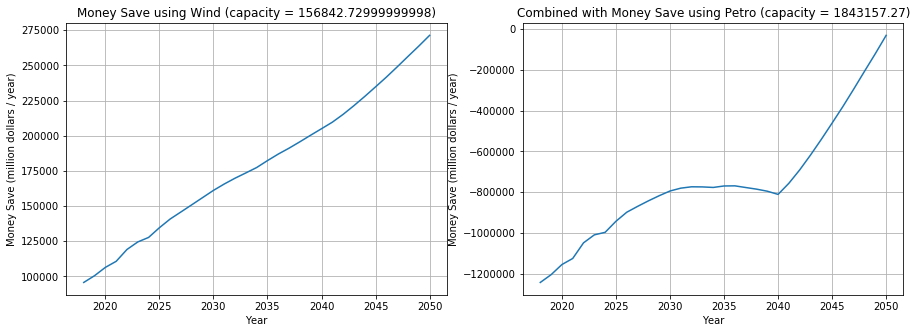

In [18]:
suggest(2, 75, 30, 1.5, 2000000)